In [1]:
import numpy as np
import cv2


def ThresholdColorChannel(image_channel, threshold=(0, 255)):
    binary_image = np.zeros_like(image_channel)
    binary_image[(image_channel >= threshold[0]) & (image_channel <= threshold[1])] = 1
    return binary_image

def AbsoluteSobelThreshold(image_channel, orient='x', sobel_kernel=3, threshold=(0, 255)):
    if (orient == 'x'):
        sobel = cv2.Sobel(image_channel, cv2.CV_64F, 1, 0)
    if (orient == 'y'):
        sobel = cv2.Sobel(image_channel, cv2.CV_64F, 0, 1)
    absolute_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*absolute_sobel/np.max(absolute_sobel))
    binary_image = np.zeros_like(scaled_sobel)
    binary_image[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    return binary_image  

def GradientMagnitudeThreshold(image_channel, sobel_kernel=3, magnitude_threshold=(0, 255)):
    sobelx = cv2.Sobel(image_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradient_magnitude)/255 
    gradient_magnitude = (gradient_magnitude/scale_factor).astype(np.uint8) 
    binary_image = np.zeros_like(gradient_magnitude)
    binary_image[(gradient_magnitude >= magnitude_threshold[0]) & (gradient_magnitude <= magnitude_threshold[1])] = 1
    return binary_image

def GradientDirectionThreshold(image_channel, sobel_kernel=3, direction_threshold=(0, np.pi/2)):
    sobel_x = cv2.Sobel(image_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absolute_gradient_direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_image =  np.zeros_like(absolute_gradient_direction)
    binary_image[(absolute_gradient_direction >= direction_threshold[0]) & (absolute_gradient_direction <= direction_threshold[1])] = 1
    return binary_image

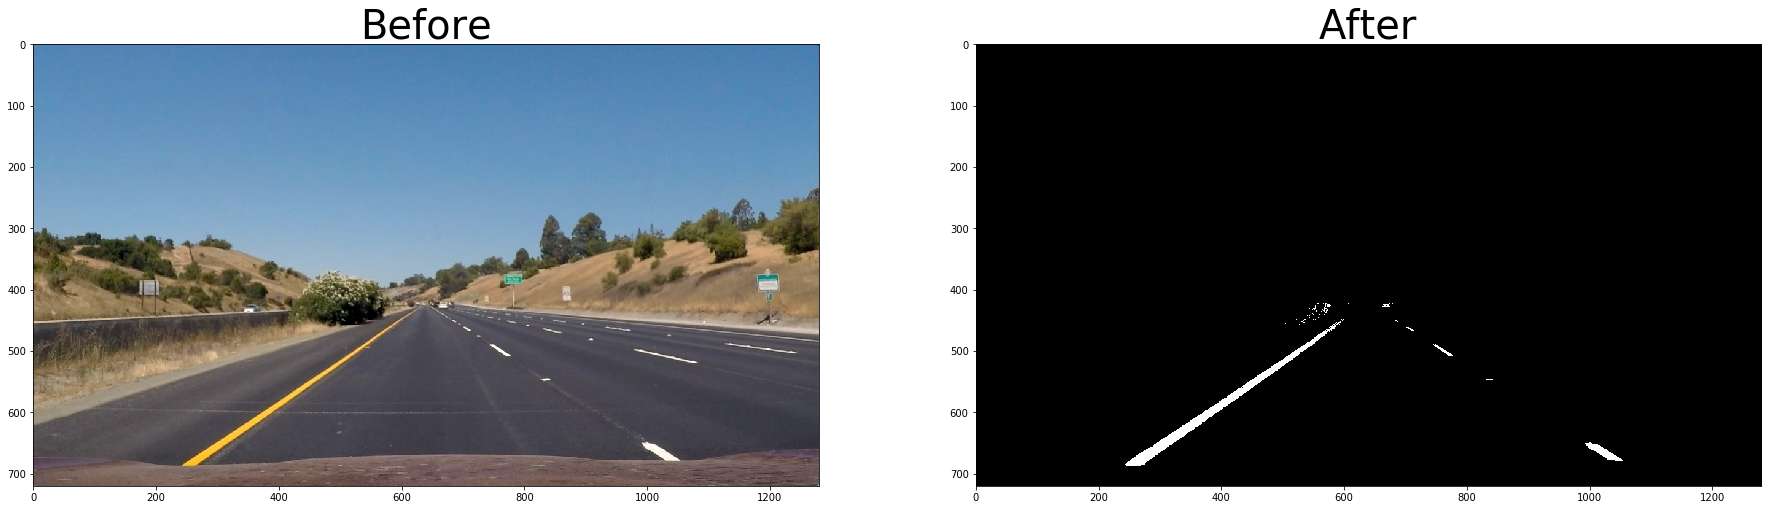

File: ./test_images/straight_lines1.jpg. Grayscale: 206-255. R: 224-255. G: 208-255. L: 192-255. S: 213-255. V: 90-254.Gradient X magnitude: 225-255. Gradient direction: 16-177


In [2]:
from ipywidgets import widgets
from ipywidgets import interact
from ipywidgets import IntRangeSlider
from ipywidgets import IntSlider
from ipywidgets import FloatRangeSlider
from ipywidgets import RadioButtons
from ipywidgets import Checkbox

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.axes as ax
import glob

def CutOutRegionOfInterest(img):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on the image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    # define vertices of 'region of interest' polygon
    img_height = img.shape[0]
    img_width = img.shape[1]
    region_of_interest = np.array([[(70, img_height),(img_width - 70, img_height), (img_width/2 + 80, img_height/2 +60), (img_width/2 - 80, img_height/2 + 60)]], dtype=np.int32)
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, region_of_interest, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def ReadColorChannels(rgb_image):
    hls_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    hsv_image_hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    greyscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    
    r_channel = rgb_image[:,:,0].astype(np.uint8)
    g_channel = rgb_image[:,:,1].astype(np.uint8)
    b_channel = rgb_image[:,:,2].astype(np.uint8)
    
    h_channel = hls_image[:,:,0].astype(np.uint8)
    l_channel = hls_image[:,:,1].astype(np.uint8)
    s_channel = hls_image[:,:,2].astype(np.uint8)
    
    v_channel = hsv_image_hsv[:,:,2].astype(np.uint8) 
    return r_channel, g_channel, b_channel, greyscale_image, h_channel, l_channel, s_channel, v_channel

def GetThresholdedBinaryImage(rgb_image, grayscale_thresh=(206,255), r_thresh=(224,255), g_thresh=(208,255), b_thresh=(192,255), l_thresh=(213,255), s_thresh=(90,254), v_thresh=(225,255),
                            kernel_size=13, grad_x_mag_thresh=(16,177), grad_y_mag_thresh=(9,177), grad_mag_thresh=(29,177), grad_dir_thresh=(0.71,1.28), apply_grad_thresh=False):
    
    r_channel, g_channel, b_channel, image_greyscale, h_channel, l_channel, s_channel, v_channel = ReadColorChannels(rgb_image)
    
    grayscale_thresholded_pixels = ThresholdColorChannel(image_greyscale, threshold=grayscale_thresh) # 206-255 white lines on bright and dark surfaces. no shadows
    r_thresholded_pixels = ThresholdColorChannel(r_channel, threshold=r_thresh) # 224-255 yellow and white lines on both bright and dark surface. no shadows 
    g_thresholded_pixels = ThresholdColorChannel(g_channel, threshold=g_thresh) # 208-255 white lines on bright and dark surfaces. no shadows
    b_thresholded_pixels = ThresholdColorChannel(b_channel, threshold=b_thresh) # 192-255 white lines on bright and dark surfaces. no shadows
    # h_channel - bad for everything
    l_thresholded_pixels = ThresholdColorChannel(l_channel, threshold=l_thresh) # 213-255 white lines on bright and dark surfaces. no shadows
    s_thresholded_pixels = ThresholdColorChannel(s_channel, threshold=s_thresh)   # 90-254 yellow lines on bright and dark surface. no shadows. bright stains can  be removed by increasing min to 174
    v_thresholded_pixels = ThresholdColorChannel(v_channel, threshold=v_thresh)   # 225-255 yellow lines on bright surface 
    
    gradient_x_magnitude = AbsoluteSobelThreshold(image_greyscale, orient='x', sobel_kernel=kernel_size, threshold=grad_x_mag_thresh)
    gradient_y_magnitude = AbsoluteSobelThreshold(image_greyscale, orient='y', sobel_kernel=kernel_size, threshold=grad_y_mag_thresh)
    gradient_magnitude = GradientMagnitudeThreshold(image_greyscale, sobel_kernel=kernel_size, magnitude_threshold=grad_mag_thresh)
    gradient_direction = GradientDirectionThreshold(image_greyscale, sobel_kernel=kernel_size, direction_threshold=grad_dir_thresh)    
    
    binary_image = np.zeros_like(image_greyscale)
    
    thresholded_gradient = (((gradient_x_magnitude==1) | (gradient_y_magnitude==1)) | ((gradient_magnitude==1) & (gradient_direction==1)))
    
    thresholded_pixels = ((r_thresholded_pixels==1) | (g_thresholded_pixels==1) | (b_thresholded_pixels==1) |
                 (l_thresholded_pixels==1) | (s_thresholded_pixels==1) | (v_thresholded_pixels==1) |
                 (grayscale_thresholded_pixels==1))
            
    binary_image[thresholded_pixels & ( thresholded_gradient if apply_grad_thresh else True) ] = 1
    
    binary_image = CutOutRegionOfInterest(binary_image)
    
    return binary_image


def DisplayBeforeAndAfter(before, after):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.set_title('Before', fontsize=40)
    im1 = ax1.imshow(before)
    ax2.set_title('After', fontsize=40)
    im2 = ax2.imshow(after, cmap='gray')
    #fig.tight_layout()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
def DisplayThresholdedImage(file_name, grayscale_thresh, r_thresh, g_thresh, b_thresh, l_thresh, s_thresh, v_thresh,
                            kernel_size, grad_x_mag_thresh, grad_y_mag_thresh, grad_mag_thresh, grad_dir_thresh, apply_grad_thresh):
    
    original_image = cv2.imread(file_name)
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
   
    
    binary_image = GetThresholdedBinaryImage(rgb_image, grayscale_thresh, r_thresh, g_thresh, b_thresh, l_thresh,
                                             s_thresh, v_thresh, kernel_size, grad_x_mag_thresh, grad_y_mag_thresh,
                                             grad_mag_thresh, grad_dir_thresh, apply_grad_thresh)
    
    DisplayBeforeAndAfter(rgb_image, binary_image)
    print("File: {}. Grayscale: {}-{}. R: {}-{}. G: {}-{}. L: {}-{}. S: {}-{}. V: {}-{}.Gradient X magnitude: {}-{}. Gradient direction: {}-{}".format(
        file_name,
        grayscale_thresh[0], grayscale_thresh[1],
        r_thresh[0], r_thresh[1],
        g_thresh[0], g_thresh[1],
        b_thresh[0], b_thresh[1],
        l_thresh[0], l_thresh[1],
        s_thresh[0], s_thresh[1],
        v_thresh[0], v_thresh[1],
        grad_x_mag_thresh[0], grad_x_mag_thresh[1],
        grad_dir_thresh[0], grad_dir_thresh[1]))


test_image_filenames = glob.glob('./test_images/*.jpg') 
image_selection_radio=RadioButtons(options=test_image_filenames, value=test_image_filenames[0], continuous_update=False, description="Image_file")
grayscale_threshold_change_slider = IntRangeSlider(min=0, max=255, step=1, value=[206,255], continuous_update=False, description="Grayscale")
r_threshold_change_slider = IntRangeSlider(min=0, max=255, step=1, value=[224,255], continuous_update=False, description="R_channel")
g_threshold_change_slider = IntRangeSlider(min=0, max=255, step=1, value=[208,255], continuous_update=False, description="G_channel")
b_threshold_change_slider = IntRangeSlider(min=0, max=255, step=1, value=[192,255], continuous_update=False, description="B_channel")
l_threshold_change_slider = IntRangeSlider(min=0, max=255, step=1, value=[213,255], continuous_update=False, description="L_channel")
s_threshold_change_slider = IntRangeSlider(min=0, max=255, step=1, value=[90,254], continuous_update=False, description="S_channel")
v_threshold_change_slider = IntRangeSlider(min=0, max=255, step=1, value=[225,255], continuous_update=False, description="V_channel")

apply_grad_threshold_checkbox = Checkbox(value=True, description="Apply_Gradient_Threshold")

sobel_kernel_change_slider = IntSlider(min=9, max=15, step=2, value=15, continuous_update=False, description="Soebel kernel")
gradient_x_magnitude_threshold_change_slider = IntRangeSlider(min=0, max=255, step=1, value=[16,177], continuous_update=False, description="Grad_X_magnitude")
gradient_y_magnitude_threshold_change_slider = IntRangeSlider(min=0, max=255, step=1, value=[9,177], continuous_update=False, description="Grad_Y_magnitude")
gradient_magnitude_threshold_change_slider = IntRangeSlider(min=0, max=255, step=1, value=[29,177], continuous_update=False, description="Grad_magnitude")
gradient_direction_threshold_change_slider = FloatRangeSlider(min=0, max=np.pi/2, step=0.01, value=[0.71, 1.28], continuous_update=False, description="Grad_direction")


interact(DisplayThresholdedImage,
         file_name = image_selection_radio,
         grayscale_thresh = grayscale_threshold_change_slider,
         r_thresh = r_threshold_change_slider,
         g_thresh = g_threshold_change_slider,
         b_thresh = b_threshold_change_slider,
         l_thresh = l_threshold_change_slider,
         s_thresh = s_threshold_change_slider,
         v_thresh = v_threshold_change_slider,
         kernel_size=sobel_kernel_change_slider,
         grad_x_mag_thresh=gradient_x_magnitude_threshold_change_slider,
         grad_y_mag_thresh=gradient_y_magnitude_threshold_change_slider,
         grad_mag_thresh=gradient_magnitude_threshold_change_slider,
         grad_dir_thresh=gradient_direction_threshold_change_slider,
         apply_grad_thresh=apply_grad_threshold_checkbox)